<a href="https://colab.research.google.com/github/rkurdyumov/control_challenges/blob/main/inverted_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install slycot   # Install python-control dependencies for Colab.
!pip install control

In [149]:
import control
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

In [180]:
# Inverted pendulum parameters, taken from:
# https://github.com/janismac/ControlChallenges/blob/gh-pages/js/models/SinglePendulum.js
m0 = 10.0 # cart mass (kg)
m1 = 0.5  # pendulum mass (kg)
g = 9.81  # (m/s^2)
L = 1.0   # pendulum length (m)
z0 = [-2.0, 0.0, 0.2, 0.0]  # initial [x0, dx0, theta, dtheta]
    
def dz_dt(t, z, K, a):
  # State update dz/dt for z = [x0, dx0, theta, dtheta].
  # The equations of motion are simplified from equations (3) and (6):
  # https://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling
  # where I = 0 and our theta = (pi - their_theta).
  #   (m0 + m1)*ddx0 + m1*L*cos(theta)*ddtheta - m1*L*dtheta^2*sin(theta) = F
  #   L*ddtheta + cos(theta) * ddx0 = g*sin(theta)
  # We have a system of equations Ax=b, where x = [ddx0, ddtheta].
  x0, dx0, theta, dtheta = z
  F = 0 if K is None else np.dot(-K, z) # Apply state feedback u = -Kz.
  A = np.array([
      [m0 + m1,       m1*L*np.cos(theta)],
      [np.cos(theta), L]])
  b = np.array([F + m1*L*np.sin(theta)*dtheta**2, g*np.sin(theta)])
  ddx0, ddtheta = np.linalg.solve(A,b)
  return [dx0, ddx0, dtheta, ddtheta]

# State space representation of the inverted pendulum on a cart, linearized
# about the upright state (a similarly simplified equation (20) from the link
# above).
A = np.array([
            [0, 1,  0,               0],
            [0, 0, -m1*g/m0,  0],
            [0, 0,  0,               1],
            [0, 0, (m0+m1)*g/(m0*L), 0]])

B = np.array([
            [0],
            [1/m0],
            [0],
            [-1/(m0*L)]])
C = np.diag([1, 1, 1, 1]) # Output all states.
D = 0

(-3.0, 6.283185307179586)

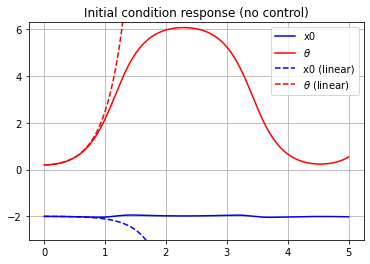

In [208]:
# Verify initial condition response (no control).
# The non-linear sim should have a swinging pendulum and back and forth cart 
# movement.
# The linear sim will behave non-physically.  It should diverge since it is 
# linearized about the upright unstable equilibrium point.

dt = 1e-4
t = np.arange(0, 5, dt)
K = None # No controller.

# Run the non-linear and linear sims.
nonlin = solve_ivp(dz_dt, [t[0], t[-1]], z0, t_eval=t, args=(K, 0))
x0, dx0, theta, dtheta = nonlin.y
_, y_lin = control.initial_response(control.ss(A, B, C, D), t, z0)
x0_lin, dx0_lin, theta_lin, dtheta_lin = y_lin

plt.plot(t, x0, 'b', label="x0")
plt.plot(t, theta, 'r', label=r"$\theta$")
plt.plot(t, x0_lin, 'b--', label="x0 (linear)")
plt.plot(t, theta_lin, 'r--', label=r"$\theta$ (linear)")
plt.title("Initial condition response (no control)")
plt.legend()
plt.grid()
plt.ylim([z0[0]-1, 2*np.pi])

3.450779388025866e-05 1.265032142976495e-06


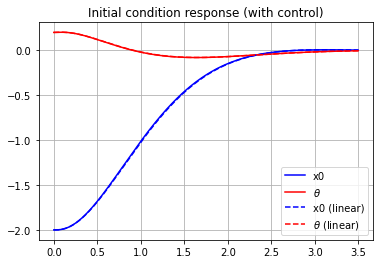

In [231]:
# Verify initial condition response (with control).
# Since the controller will keep the pendulum close to upright, the linear sim
# should stay reasonably accurate.

dt = 1e-4
t = np.arange(0, 3.5, dt)
K = np.array([-110, -160, -1100, -400]) # Sample solution given in challenge.

# Run the non-linear and linear sims.
nonlin = solve_ivp(dz_dt, [t[0], t[-1]], z0, t_eval=t, args=(K, 0))
x0, dx0, theta, dtheta = nonlin.y
_, y_lin = control.initial_response(control.ss(A-B*K, B, C, D), t, z0)
x0_lin, dx0_lin, theta_lin, dtheta_lin = y_lin

plt.plot(t, x0, 'b', label="x0")
plt.plot(t, theta, 'r', label=r"$\theta$")
plt.plot(t, x0_lin, 'b--', label="x0 (linear)")
plt.plot(t, theta_lin, 'r--', label=r"$\theta$ (linear)")
plt.title("Initial condition response (with control)")
plt.legend()
plt.grid()

# There's almost no difference between the linear and non-linear sims when we
# stay upright.
mse_x0 = np.power(x0 - x0_lin, 2).mean()
mse_theta = np.power(theta - theta_lin, 2).mean()
print(mse_x0, mse_theta)

[-100.         -120.16301106 -762.19526958 -243.6292226 ]
0.00015062263018758289 1.1069721197062142e-05


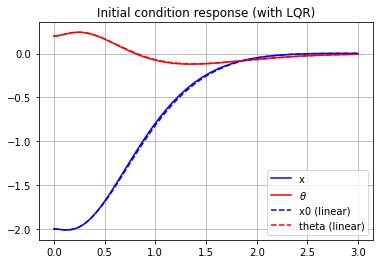

In [242]:
# LQR

# Q assigns weights to errors in each state variable.
Q = np.diag([10000, 1000, 1000, 1000])  # Trial & error, exceeds Fmax = 50N.
# Leave R as 1 and scale Q to trade off control effort vs error.
R = 1
K, S, E = control.lqr(A, B, Q, R)
K = np.asarray(K).flatten()
print(K)

dt = 1e-4
t = np.arange(0, 3.0, dt)

_, y_lqr = control.initial_response(control.ss(A-B*K, B, C, 0), t, z0)
x0_lin, dx0_lin, theta_lin, dtheta_lin = y_lqr
sol = solve_ivp(dz_dt, [t[0], t[-1]], z0, t_eval=t, args=(K, 0))
x0, dx0, theta, dtheta = sol.y
#u = np.dot(-K, sol.y)

plt.plot(t, x0, 'b', label="x")
plt.plot(t, theta, 'r', label=r"$\theta$")
plt.plot(t, x0_lin, 'b--', label="x0 (linear)")
plt.plot(t, theta_lin, 'r--', label="theta (linear)")
plt.title("Initial condition response (with LQR)")
plt.legend()
plt.grid()

mse_x0 = np.power(x0 - x0_lin, 2).mean()
mse_theta = np.power(theta - theta_lin, 2).mean()
print(mse_x0, mse_theta)

In [148]:
K, S, E = control.lqr(A, B, Q, R)

K = np.asarray(K).flatten()
print(K)


[-100.         -120.16301106 -762.19526958 -243.6292226 ]
